In [1]:
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import font_manager as fm
from cycler import cycler

from tools import load, split, estimate_derivative, pseudoderivative
import numpy as np
from scipy.stats import pearsonr

In [2]:
# path = r"/home/p308270/.local/share/fonts/Helvetica.ttf"  # or .otf
# path = r"/home/ton20/.local/share/fonts/Helvetica.ttf"  # or .otf

# fm.fontManager.addfont(path)
plt.rcParams["font.family"] = 'Helvetica'

plt.rcParams['legend.fontsize'] = 12
plt.rcParams.update({
    "font.size": 12,
    "axes.labelsize": 12,
    "axes.titlesize": 14,
    "legend.fontsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.grid": False,

    "lines.linewidth": 1.5,     # default line width
    "axes.linewidth": 1.,      # axis spine width
    'xtick.major.width': 1.0,
    'ytick.major.width': 1.0,
    'xtick.major.size': 6,
    'ytick.major.size': 6,
    'xtick.minor.width': 1.0,
    'ytick.minor.width': 1.0,

    "hatch.linewidth": 1.,   # make hatch strokes visible

})

palette = ['#405cca', '#c23232', '#269f30', '#1d1d1d']
cmap = ListedColormap(palette, name='custom')

plt.rcParams['axes.prop_cycle'] = cycler(color=palette)

In [3]:
import numpy as np
from math import sqrt, pi, exp
from scipy.stats import norm
from scipy.integrate import quad

def _phi(x):
    return (1.0 / sqrt(2.0 * pi)) * exp(-0.5 * x * x)

def K(r, s, atol=1e-12, rtol=1e-10):
    """
    Stable K(r, s) using Mehler's formula + numerical quadrature.
    Valid for -1 < r <= 1 (clip r just below 1 for numerical safety).
    """
    if not (0.0 < s < 1.0):
        raise ValueError("s must be in (0,1).")

    # keep r in (-1, 1); allow r=1 by integrating to 1-eps
    r = float(r)
    if r >= 1.0:
        r = np.nextafter(1.0, 0.0)
    if r <= -1.0:
        r = np.nextafter(-1.0, 0.0)

    t = float(norm.ppf(s))
    phi_t = _phi(t)
    scale = (phi_t / (1.0 - s))**2

    def S(u):
        # integrand from Mehler (probabilists' Hermite)
        return (1.0 / np.sqrt(1.0 - u*u)) * np.exp((t*t) * (u / (1.0 + u)))

    I, err = quad(S, 0.0, r, epsabs=atol, epsrel=rtol, limit=200)
    return (1.0 - s) + scale * I

In [4]:
n_hd = 10000
n_out = 3
k = 50
n_train = 450

filename = '1_600_20'

sensor_data, sequence, times_sec, sequence_sec = load(filename, reduced=True)
d_sensor_data = np.apply_along_axis(pseudoderivative, axis=0, arr=sensor_data)
sensor_data = np.hstack((sensor_data, d_sensor_data))

x_dense = sensor_data
row_norms = np.linalg.norm(x_dense, axis=1, keepdims=True)
x_dense = x_dense / row_norms

n_dense = x_dense.shape[1]

labels = np.zeros_like(times_sec)
for i, t in enumerate(sequence_sec[:n_train]):
    try:
        flag = (times_sec > sequence_sec[i]) & (times_sec < sequence_sec[i+1])
    except IndexError:
        flag = (times_sec > sequence_sec[i])
    labels[flag] = int(sequence[i][1])

idx_first_flag = np.where(labels != 0)[0][0]
# idx_last_flag = np.where(labels != 0)[0][-1]

W_hd = np.random.binomial(n=1, p=0.05, size=(n_hd, n_dense))  #Test random sparse weights
x_hd = x_dense @ W_hd.T
z_hd = np.where(np.argsort(x_hd)<k, 1., 0)

In [5]:
n_pairs = 10000

x = []
y = []

x_dense = x_dense[idx_first_flag:]
z_hd = z_hd[idx_first_flag:]

for i in range(n_pairs):
    idx1, idx2 = np.random.choice(z_hd.shape[0], size=2, replace=False)
    x.append(np.dot(x_dense[idx1], x_dense[idx2])/(np.linalg.norm(x_dense[idx1])*np.linalg.norm(x_dense[idx2])))
    y.append(np.dot(z_hd[idx1], z_hd[idx2])/k)
    # x.append(pearsonr(x_dense[idx1], x_dense[idx2])[0])
    # y.append(pearsonr(z_hd[idx1], z_hd[idx2])[0])

s = 1 - k/n_hd
# s = 1 - 1e-3
rs = np.arange(0, 1.01, 0.01)
vals = [K(r=ri, s=s)*(1-s) for ri in rs]

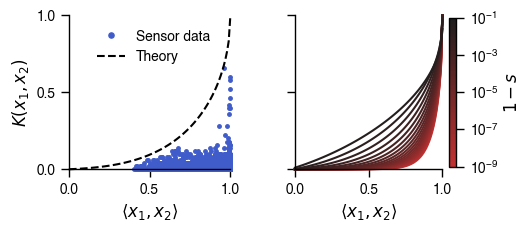

In [6]:
from matplotlib.colors import LinearSegmentedColormap, LogNorm
from matplotlib.cm import ScalarMappable

# graded_cmap = LinearSegmentedColormap.from_list('green_to_dark', ["#269f30", "#1d1d1d"], N=100)
graded_cmap = LinearSegmentedColormap.from_list('red_to_dark', ["#c23232", "#1d1d1d"], N=100)


fig, ax = plt.subplots(1, 2, figsize=(5,2), gridspec_kw={'wspace': 0.4})
ax0 = ax[0]
ax1 = ax[1]

ax0.plot(x, y, '.', alpha=1., ms=5, clip_on=False, label='Sensor data')
ax0.plot(rs, vals, '--', color='black', linewidth=1.5, clip_on=False, label='Theory')
ax0.set_ylabel(r'$K({x}_{1}, {x}_{2})$')
ax0.set_xlabel(r'$\langle {x}_{1}, {x}_{2} \rangle $')
ax0.legend(bbox_to_anchor=(0.95, 0.99), frameon=False, fontsize=10,
          markerscale=1.5)
ax0.set_xlim(0,1)
ax0.set_ylim(0,1)
ax0.set_xticks([0, 0.5, 1])
ax0.set_yticks([0, 0.5, 1])

density = np.logspace(-9, -1, 20)
rs = np.arange(0, 1.01, 0.01)
# Normalize in log space so color matches density values
norma = LogNorm(vmin=density.min(), vmax=density.max())
sm = ScalarMappable(norm=norma, cmap=graded_cmap)  # mappable for colorbar

for i, d in enumerate(density):
    s = 1 - d
    vals = [K(r=ri, s=s)*(1-s) for ri in rs]
    ax1.plot(rs, vals, color=graded_cmap(int((100./len(density))*i)), clip_on=False,)

# Add colorbar for the right subplot
cbar = fig.colorbar(sm, ax=ax1, fraction=0.046, pad=0.04)
cbar.set_label('$1-s$')
cbar.set_ticks([1e-9, 1e-7, 1e-5, 1e-3, 1e-1])

ax1.set_xlim(0,1)
ax1.set_ylim(0,1)
ax1.set_xticks([0, 0.5, 1])
ax1.set_yticks([0, 0.5, 1], labels=[])
ax1.set_xlabel(r'$\langle {x}_{1}, {x}_{2} \rangle $')
# pycharm is for the weak
plt.savefig('figs/kernel_shape.pdf', bbox_inches='tight')
plt.savefig('figs/kernel_shape.png', bbox_inches='tight', dpi=300)

plt.show()

In [7]:
k=10
p_sweep = [0.01, 0.02, 0.05, 0.1]
s = 1 - k/n_hd
# s = 1 - 1e-3

x_list = []
y_list = []

for p in p_sweep:

    W_hd = np.random.binomial(n=1, p=p, size=(n_hd, n_dense))  #Test random sparse weights
    x_hd = x_dense @ W_hd.T
    z_hd = np.where(np.argsort(x_hd)<k, 1., 0)

    n_pairs = 10000

    x = []
    y = []

    for i in range(n_pairs):
        idx1, idx2 = np.random.choice(z_hd.shape[0], size=2, replace=False)
        x.append(np.dot(x_dense[idx1], x_dense[idx2])/(np.linalg.norm(x_dense[idx1])*np.linalg.norm(x_dense[idx2])))
        y.append(np.dot(z_hd[idx1], z_hd[idx2])/k)

    x_list.append(x)
    y_list.append(y)

rs = np.arange(0, 1.01, 0.01)
vals = [K(r=ri, s=s)*(1-s) for ri in rs]

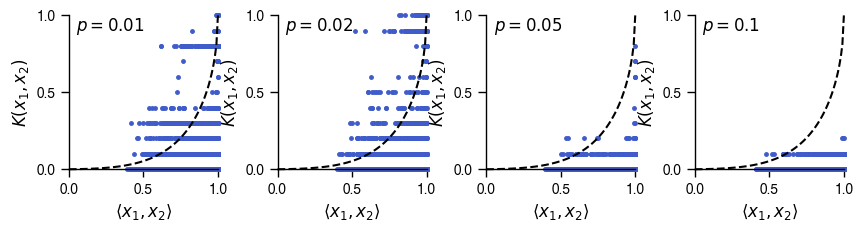

In [8]:
fig, ax = plt.subplots(1, 4, figsize=(10,2), gridspec_kw={'wspace': 0.4})

for i,a in enumerate(ax.flatten()):
    x = x_list[i]
    y = y_list[i]
    a.plot(x, y, '.', alpha=1., ms=5, clip_on=False, label='Sensor data')
    a.plot(rs, vals, '--', color='black', linewidth=1.5, clip_on=False, label='Theory')
    a.set_ylabel(r'$K({x}_{1}, {x}_{2})$')
    a.set_xlabel(r'$\langle {x}_{1}, {x}_{2} \rangle $')
    # a.legend(bbox_to_anchor=(0.95, 0.99), frameon=False, fontsize=10,
    #    markerscale=1.5)
    a.set_xlim(0,1)
    a.set_ylim(0,1)
    a.set_xticks([0, 0.5, 1])
    a.set_yticks([0, 0.5, 1])
    a.text(0.05, 0.9, f'$p={p_sweep[i]}$', transform=a.transAxes)

# plt.savefig('figs/kernel_shape.pdf', bbox_inches='tight')
plt.show()

In [9]:
k_sweep = [10, 50, 250, 1250]

x_list = []
y_list = []
vals_list = []

rs = np.arange(0, 1.01, 0.01)

for k in k_sweep:
    s = 1 - k/n_hd

    W_hd = np.random.binomial(n=1, p=0.05, size=(n_hd, n_dense))  #Test random sparse weights
    x_hd = x_dense @ W_hd.T
    z_hd = np.where(np.argsort(x_hd)<k, 1., 0)

    n_pairs = 10000

    x = []
    y = []

    for i in range(n_pairs):
        idx1, idx2 = np.random.choice(z_hd.shape[0], size=2, replace=False)
        x.append(np.dot(x_dense[idx1], x_dense[idx2])/(np.linalg.norm(x_dense[idx1])*np.linalg.norm(x_dense[idx2])))
        y.append(np.dot(z_hd[idx1], z_hd[idx2])/k)

    x_list.append(x)
    y_list.append(y)

    vals = [K(r=ri, s=s)*(1-s) for ri in rs]
    vals_list.append(vals)

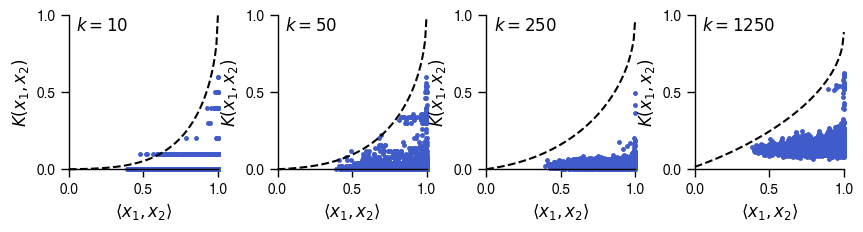

In [10]:
fig, ax = plt.subplots(1, 4, figsize=(10,2), gridspec_kw={'wspace': 0.4})

for i,a in enumerate(ax.flatten()):
    x = x_list[i]
    y = y_list[i]
    vals = vals_list[i]
    a.plot(x, y, '.', alpha=1., ms=5, clip_on=False, label='Sensor data')
    a.plot(rs, vals, '--', color='black', linewidth=1.5, clip_on=False, label='Theory')
    a.set_ylabel(r'$K({x}_{1}, {x}_{2})$')
    a.set_xlabel(r'$\langle {x}_{1}, {x}_{2} \rangle $')
    # a.legend(bbox_to_anchor=(0.95, 0.99), frameon=False, fontsize=10,
    #    markerscale=1.5)
    a.set_xlim(0,1)
    a.set_ylim(0,1)
    a.set_xticks([0, 0.5, 1])
    a.set_yticks([0, 0.5, 1])
    a.text(0.05, 0.9, f'$k={k_sweep[i]}$', transform=a.transAxes)

# plt.savefig('figs/kernel_shape.pdf', bbox_inches='tight')
plt.show()